# Evaluating Classification Models
This notebook demonstrates how to train, evaluate, and compare classification models (KNN and SVM) using the breast cancer dataset. It includes data preprocessing, model training, and comprehensive evaluation metrics analysis.

## Objectives
- Load and preprocess the breast cancer dataset for classification
- Apply feature scaling and add noise to simulate real-world measurement variability
- Train and compare K-Nearest Neighbors and Support Vector Machine classifiers
- Analyze model performance using multiple evaluation metrics including accuracy, precision, recall, and confusion matrices

In [1]:
# Import essential libraries for data science and machine learning
import numpy as np                    # For numerical operations, array handling, and random number generation
import pandas as pd                   # For data manipulation, analysis, and DataFrame operations
from sklearn.datasets import load_breast_cancer    # Pre-processed breast cancer dataset from UCI
from sklearn.preprocessing import StandardScaler   # For feature standardization (mean=0, std=1)
from sklearn.model_selection import train_test_split  # For creating train/test splits with stratification
from sklearn.neighbors import KNeighborsClassifier    # Instance-based learning with K-Nearest Neighbors
from sklearn.svm import SVC                          # Support Vector Machine for classification tasks
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Model evaluation tools
import matplotlib.pyplot as plt      # For data visualization and creating plots
import seaborn as sns                # For enhanced statistical visualizations and heat maps

In [2]:
# Load the Wisconsin Breast Cancer dataset from scikit-learn
# This widely-used dataset contains features computed from digitized images of breast mass cell nuclei
data = load_breast_cancer()

# Extract features (X) and target labels (y)
X = data.data                    # Feature matrix: 30 numerical features describing cell nuclei characteristics
y = data.target                  # Target vector: 0=malignant (cancerous), 1=benign (non-cancerous)
feature_names = data.feature_names  # Names of the 30 features (including radius, texture, perimeter, area, etc.)
labels = data.target_names          # Class names: ['malignant', 'benign']

# Display basic information about the dataset
print('Loaded dataset with', X.shape[0], 'samples and', X.shape[1], 'features')
print('Classes:', labels)
print('Features include:', feature_names[:5], '... and 25 more')

Loaded dataset with 569 samples and 30 features
Classes: ['malignant' 'benign']
Features include: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness'] ... and 25 more


In [4]:
# Step 1: Standardize the features to have mean=0 and std=1
# Standardization is crucial as features have vastly different scales and units of measurement
# This ensures all features contribute equally to distance calculations in KNN and SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Add Gaussian noise to simulate real-world measurement errors and data variability
# In clinical settings, measurements often contain equipment noise and human measurement error
# Adding controlled noise helps evaluate model robustness against real-world variability
np.random.seed(42)                   # Set seed for reproducible results
noise_factor = 0.5                   # Controls the noise magnitude (0.5 = moderate noise level)
noise = np.random.normal(loc=0.0, scale=1.0, size=X.shape)  # Generate Gaussian random noise
X_noisy = X_scaled + noise_factor * noise    # Apply noise to the standardized features

# Step 3: Create DataFrames for easier data inspection and visualization
df_original = pd.DataFrame(X_scaled, columns=feature_names)
df_noisy = pd.DataFrame(X_noisy, columns=feature_names)

# Display first few rows to compare original and noise-augmented data
print("Original standardized data (first 5 rows):")
print(df_original.head())

print("\nNoisy data (first 5 rows):")
print(df_noisy.head())

Original standardized data (first 5 rows):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   
2     1.579888      0.456187        1.566503   1.558884         0.942210   
3    -0.768909      0.253732       -0.592687  -0.764464         3.283553   
4     1.750297     -1.151816        1.776573   1.826229         0.280372   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          3.283515        2.652874             2.532475       2.217515   
1         -0.487072       -0.023846             0.548144       0.001392   
2          1.052926        1.363478             2.037231       0.939685   
3          3.402909        1.915897             1.451707       2.867383   
4          0.539340        1.371011             1.428493      -0.009560   

   mean fractal dimension  ...  worst radius  wor

In [5]:
# Split the noisy dataset into training and testing sets 
# A 70/30 split balances having enough training data while ensuring robust evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y, 
    test_size=0.3,        # Reserve 30% for testing (unbiased performance evaluation)
    random_state=42,      # Ensures reproducible train/test splits across runs
    stratify=y           # Maintains class distribution in both sets (important for imbalanced data)
)

# Initialize two different classification algorithms with complementary strengths
# 1. K-Nearest Neighbors (KNN): A non-parametric, instance-based learning method
# KNN makes predictions based on the majority class of the k closest training samples
knn = KNeighborsClassifier(
    n_neighbors=5        # k=5 balances between noise sensitivity (k too small) and majority class bias (k too large)
)

# 2. Support Vector Machine (SVM): A powerful boundary-based classifier
# SVM finds the optimal hyperplane that maximizes the margin between classes
svm = SVC(
    kernel='linear',     # Linear kernel works well for high-dimensional data with good class separation
    C=1.0,              # C=1.0 provides balanced regularization (preventing overfitting)
    random_state=42     # Ensures reproducible results for non-deterministic aspects
)

# Train both models on the training data
print("Training models on", X_train.shape[0], "samples...")
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)

print("✓ KNN model trained")
print("✓ SVM model trained")

Training models on 398 samples...
✓ KNN model trained
✓ SVM model trained


In [6]:
# Apply trained models to make predictions on the unseen test set
print("Making predictions on", X_test.shape[0], "test samples...")

# Generate predictions from both classifier models
y_pred_knn = knn.predict(X_test)    # KNN classification results
y_pred_svm = svm.predict(X_test)    # SVM classification results

# Calculate and display accuracy scores (proportion of correct predictions)
# Accuracy = (True Positives + True Negatives) / (Total Samples)
# While useful for overall performance, accuracy alone can be misleading for imbalanced classes
knn_accuracy = accuracy_score(y_test, y_pred_knn)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Display formatted accuracy results for easy comparison
print(f"KNN Test Accuracy: {knn_accuracy:.3f} ({knn_accuracy*100:.1f}%)")
print(f"SVM Test Accuracy: {svm_accuracy:.3f} ({svm_accuracy*100:.1f}%)")

# Compare models based on accuracy metric
if svm_accuracy > knn_accuracy:
    print("→ SVM performs better on this dataset by accuracy metric")
elif knn_accuracy > svm_accuracy:
    print("→ KNN performs better on this dataset by accuracy metric")

else:    print("→ Both models perform equally well by accuracy metric")

Making predictions on 171 test samples...
KNN Test Accuracy: 0.942 (94.2%)
SVM Test Accuracy: 0.930 (93.0%)
→ KNN performs better on this dataset by accuracy metric
KNN Test Accuracy: 0.942 (94.2%)
SVM Test Accuracy: 0.930 (93.0%)
→ KNN performs better on this dataset by accuracy metric


In [8]:
# Generate comprehensive classification performance reports for both models
# These reports provide deeper insights beyond simple accuracy metrics

print("=" * 60)
print("KNN CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred_knn, target_names=labels))

print("\n" + "=" * 60)
print("SVM CLASSIFICATION REPORT") 
print("=" * 60)
print(classification_report(y_test, y_pred_svm, target_names=labels))

print("\nKey Metrics Explained:")
print("• Precision: Ability to avoid false positives - TP/(TP+FP)")
print("  (High precision means when the model predicts malignant, it's usually correct)")
print("• Recall: Ability to find all positives - TP/(TP+FN)")
print("  (High recall means the model catches most malignant cases, critical for medical diagnosis)")

print("• F1-Score: Balanced metric combining precision and recall - 2*(Precision*Recall)/(Precision+Recall)")
print("• Support: Actual number of samples in each class in the test set")
print("  (Higher is better, especially useful when classes are imbalanced)")

KNN CLASSIFICATION REPORT
              precision    recall  f1-score   support

   malignant       0.92      0.92      0.92        64
      benign       0.95      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171


SVM CLASSIFICATION REPORT
              precision    recall  f1-score   support

   malignant       0.89      0.92      0.91        64
      benign       0.95      0.93      0.94       107

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171


Key Metrics Explained:
• Precision: Ability to avoid false positives - TP/(TP+FP)
  (High precision means when the model predicts malignant, it's usually correct)
• Recall: Ability to find all positives - TP/(TP+FN)
  (High recall means the model catches most malignant cases, critical for me

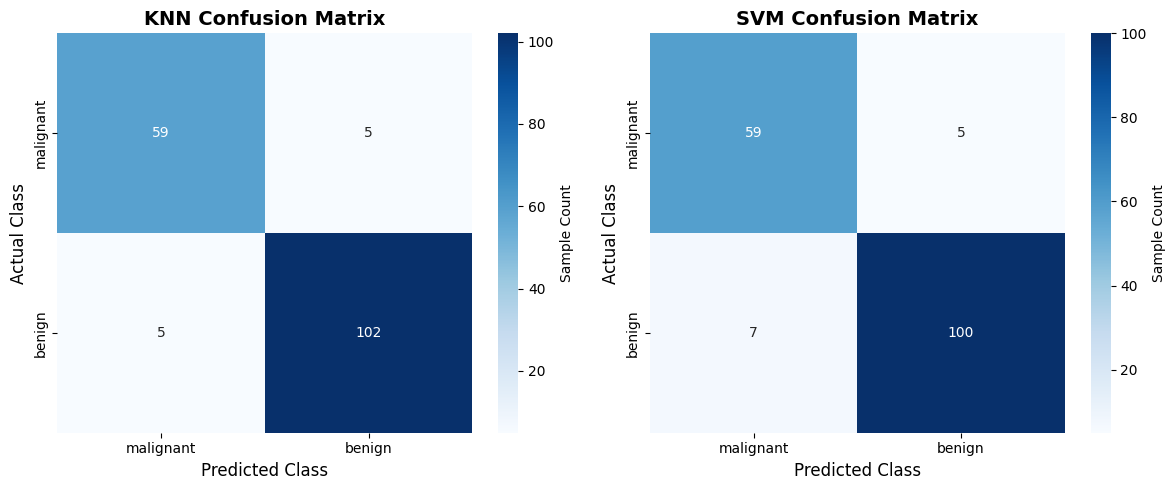


Confusion Matrix Interpretation for Cancer Diagnosis:
• Top-left (TN): True Negatives - Correctly identified benign tumors
• Top-right (FP): False Positives - Benign tumors incorrectly classified as malignant
  (May cause unnecessary stress and treatment, but less dangerous than FN)
• Bottom-left (FN): False Negatives - Malignant tumors incorrectly classified as benign
  (CRITICAL ERROR: Missed cancer diagnoses could delay treatment and risk patient health)
• Bottom-right (TP): True Positives - Correctly identified malignant tumors

In medical applications, minimizing False Negatives is typically prioritized over
than unnecessarily flagging a benign tumor for further investigation.
minimizing False Positives, as missing a cancer diagnosis has more severe consequences


In [11]:
# Create and visualize confusion matrices for detailed error analysis of both models
# Confusion matrices provide the clearest view of where models make specific types of errors

# Calculate confusion matrices (2x2 tables of actual vs predicted classes)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Create side-by-side heatmap visualizations for direct model comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# KNN confusion matrix visualization (left subplot)
sns.heatmap(cm_knn, annot=True, fmt='d', ax=axes[0], cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Sample Count'})
axes[0].set_title('KNN Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Class', fontsize=12)
axes[0].set_ylabel('Actual Class', fontsize=12)

# SVM confusion matrix visualization (right subplot)
sns.heatmap(cm_svm, annot=True, fmt='d', ax=axes[1], cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Sample Count'})
axes[1].set_title('SVM Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Class', fontsize=12)
axes[1].set_ylabel('Actual Class', fontsize=12)

plt.tight_layout()
plt.show()

# Comprehensive explanation of confusion matrix interpretation for medical context
print("\nConfusion Matrix Interpretation for Cancer Diagnosis:")
print("• Top-left (TN): True Negatives - Correctly identified benign tumors")
print("• Top-right (FP): False Positives - Benign tumors incorrectly classified as malignant")
print("  (May cause unnecessary stress and treatment, but less dangerous than FN)")
print("• Bottom-left (FN): False Negatives - Malignant tumors incorrectly classified as benign")
print("  (CRITICAL ERROR: Missed cancer diagnoses could delay treatment and risk patient health)")
print("• Bottom-right (TP): True Positives - Correctly identified malignant tumors")

print("\nIn medical applications, minimizing False Negatives is typically prioritized over")
print("than unnecessarily flagging a benign tumor for further investigation.")
print("minimizing False Positives, as missing a cancer diagnosis has more severe consequences")

## Notes
- This notebook demonstrates model evaluation techniques applied to breast cancer classification
- Run all cells sequentially to see visualizations and complete evaluation metrics

- Consider experimenting with different model parameters (e.g., KNN's n_neighbors, SVM's kernel/C) to observe how they affect performance- For real-world applications, cross-validation would provide more robust performance estimates